In [90]:
import os 
import json 
import pandas as pd 
import polars as pl 
import numpy as np
from tqdm import tqdm 
import time 
from datetime import timedelta
import sys
import os
from stochastic_upper_mpc_cvxpy import step_upper_level, UMPCDataBuffer
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import numpy as np 

%load_ext autoreload
%autoreload 2

#set seed for reproducibility
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
#time = pl.read_parquet(os.path.join(data_path_wsl, "sim_data/sim_data_1h_full.par"))
#upper_mpc_data_pan = pl.read_parquet(os.path.join(data_path_wsl, "sim_data/sim_data_1h_full.par"))
#p1= pl.read_parquet("/home/alqua/data/data_vdfs/pump1_power_siso.par").group_by_dynamic(index_column="time", every="1h").agg(pl.col("pump1_power").mean())
#p4= pl.read_parquet("/home/alqua/data/data_vdfs/pump4_power_siso.par").group_by_dynamic(index_column="time", every="1h").agg(pl.col("pump4_power").mean())
#p3= pl.read_parquet("/home/alqua/data/data_vdfs/pump3_power_siso.par").group_by_dynamic(index_column="time", every="1h").agg(pl.col("pump3_power").mean())
#pumps_df = p1.join(p4, on="time").join(p3, on="time")
#baseline_df = (pumps_df.group_by("hours").agg(
#                    pl.col("energy_cons").mean().alias("mean_energy_cons"),
#                    pl.col("energy_cons").std().alias("std_energy_cons")
#                ).sort("hours"))

In [92]:
data_path_wsl = "/home/alqua/data/pump_station_data/"
data = pl.read_parquet('/home/alqua/papers/mbs_flexibility_mpc_rev_v1/mpc/input_data/aggregated_data_for_mpc.par')

In [93]:
start_date = pd.to_datetime("2023-01-11 00:00:00+00:00")
end_date = pd.to_datetime("2023-05-28 14:00:00+00:00")

data = data.filter((pl.col("time") >= start_date) & 
                   (pl.col("time") <= end_date)
                  ).with_columns(
                      pl.col("CO2Emission")/1000, #Kg/Kwh
                      pl.col("price")/1000 # 90 eur/ton -> 0.09eur per kg
                  )

data = data.with_columns(
    (pl.col("price") + 0.166), 
    (pl.col("CO2Emission") * 0.09))



In [94]:
new_cols_map = {
    'time': 'time_utc',
    'inflow': 'inflow_kf', 
    'inflow_0.1': 'inflow_q10', 
    'inflow_0.5': 'inflow_q50', 
    'inflow_0.9': 'inflow_q90', 
    'price': 'da_price',
    'CO2Emission': 'co2_progn'}

data = data.select(new_cols_map).rename(new_cols_map)
data = data.with_columns((pl.col("inflow_kf") - pl.col("inflow_q50")).alias("resid"))
data = data.with_columns(pl.col("resid") - pl.col("resid").mean())
data = data.with_columns(pl.when(pl.col("resid").abs() > 180).then(0).otherwise(pl.col("resid")).alias("resid"))

In [95]:
#_ = plt.hist(np.clip(data["resid"], -120,120), bins= 50, density=True)
#_ = plt.hist(np.random.normal(0,50, size=data["resid"].shape[0]), bins= 50, density=True)
#_ = plt.hist(np.clip(data["resid"], -80, 80), bins=100, density=True)

In [96]:
with open('../input_data/lower_mpc_coefficients.json', 'r') as json_file:
    models_coefficients = json.load(json_file)

In [97]:
umpc_data = UMPCDataBuffer()

In [98]:
umpc_ini = {
    'time_utc': np.nan,        
    'qout': 360,               
    'qin': 351.382888,         
    'qin_q10': 143.373214,     
    'qin_q50': 330.127912,     
    'qin_q90': 502.281903,     
    'height_ref':70 ,          
    'height_ref_scen':70 ,          
    'energy_ref': 20,          
    'co2_progn': 0.0882,       
    'da_price': 0.18384,       
    'objective': 0,            
    'opt_time_umpc':0          
}

In [99]:
horizon = 24
num_scenarios = 40
error_samples = data["resid"].to_numpy()

In [100]:
residuals = np.random.normal(0, 15, size=(num_scenarios, horizon))
residuals = np.clip(residuals, -80, 80)

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import warnings
import polars as pl 
import matplotlib.pyplot as plt 
from matplotlib.ticker import AutoMinorLocator

warnings.filterwarnings('ignore', module='matplotlib')

slice_df = data.select(pl.col(["time_utc", "inflow_kf", "co2_progn","da_price", 'inflow_q10', 'inflow_q50','inflow_q90']))
inflow_kf = slice_df["time_utc", "inflow_kf"].upsample(every="1m", time_column= "time_utc").fill_null(strategy="forward")["inflow_kf"]
slice_df = slice_df[23:-15]
slice_df = slice_df.with_columns((pl.col("inflow_kf") - pl.col("inflow_q50")).alias("resid"))

zs = 3 
N = 60
#horizon = 24
step_size = 1
max_start = len(slice_df) - horizon + 1
start_index = 0
trigger = [1, 0, 0]
#cvar_levels = [0.3, 0.5, 0.75, 0.85, 0.90, 0.95, 0.99]
cvar_levels = [0.99]
for cvar_alpha in cvar_levels:
    umpc_data = UMPCDataBuffer()
    umpc_data.initialize(umpc_ini)
    upper_violation = []
    lower_violation = []

    with tqdm(total=max_start, desc="Hour Steps") as pbar:
        start_index = 0
        while start_index < max_start:
            prices_values = slice_df["da_price"][start_index : start_index + horizon]
            co2_values = slice_df["co2_progn"][start_index : start_index + horizon]
            inflow_values = slice_df["inflow_kf"][start_index : start_index + horizon]
            #residuals = np.random.choice(error_samples, size=(num_scenarios, horizon), replace=True)
            #resid = slice_df["resid"][start_index : start_index + horizon]
            #print(slice_df["inflow_kf"][start_index : start_index + horizon])
            ############################################### Upper Level Optimization
            
            umpc_opt_results = step_upper_level(
                horizon=horizon,
                prices_values=prices_values,
                co2_progn_values=co2_values,
                inflow_values=inflow_values.to_numpy(),
                h_ini=np.array(umpc_data.data['height_ref'][-1]),
                energy_init=umpc_data.data["energy_ref"][-1],
                Qout_init=umpc_data.data["qout"][-1], 
                resid=residuals ,
                num_scenarios=num_scenarios,
                cvar_alpha = cvar_alpha)
                
            #umpc_opt_results["opt_time_umpc"] = end_time_umpc
            umpc_opt_results["qin_q10"] = slice_df["inflow_q10"][start_index]
            umpc_opt_results["qin_q50"] = slice_df["inflow_q50"][start_index]
            umpc_opt_results["qin_q90"] = slice_df["inflow_q90"][start_index]
            umpc_opt_results["time_utc"] = slice_df["time_utc"][start_index]
            umpc_data.update(umpc_opt_results)

            ############################################### Lower Level Optimization
            start_index += 1
            pbar.update(step_size)
            if start_index == 24*30:
                break
    opt_data = umpc_data.to_dataframe(save=False, skip_ini=True)
    height_array = opt_data['height_ref_scen'].to_numpy()
    violations = (height_array < 70) | (height_array > 250)
    violation_prob = np.sum(violations)/(num_scenarios * horizon)
    print('#############')
    # print probability of violations
    print(f"Probability of violations: {violation_prob}")
    print(f"cvar_alpha: {cvar_alpha}")
    print("Objective mean: ", opt_data['objective'].mean())

Hour Steps: 100%|██████████| 395/395 [22:39<00:00,  3.44s/it]

#############
Probability of violations: 1.6458333333333333
cvar_alpha: 0.99
Objective mean:  2300.6834161188945


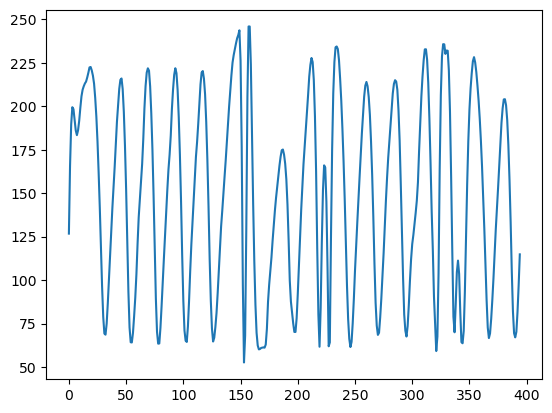

In [103]:
plt.plot(opt_data["height_ref"])